<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style=\"white-space: nowrap\">Neural Signals and Signal Processing (NX-421)</h2>
<hr style=\"clear:both\"></hr>
<h1><font color='black'>Laboratory exercise: Basics of the General Linear Model</font></h1>

## 0. Additional packages
For this lab, we will require some packages!

In [1]:
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"

###################
# Load other relevant libraries for the lab
##################
import fsl.wrappers, statsmodels
from fsl.wrappers import fslmaths
import dipy
import os.path as op
import nibabel as nib

In [2]:
%gui wx

Gtk-Message: 19:59:54.261: Failed to load module "canberra-gtk-module"


In [3]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

19:59:54: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:59:54: Debug: Adding duplicate animation handler for '1' type
19:59:54: Debug: Adding duplicate animation handler for '2' type
19:59:55: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:59:55: Debug: Adding duplicate animation handler for '1' type
19:59:55: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:10073): Gtk-CRITICAL **: 19:59:55.462: gtk_window_resize: assertion 'height > 0' failed


# 1. Fixed effect or random effect?


<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>What are linear mixed models and why are they useful? </b></p>
        <p style='text-indent: 10px;'> Suppose you have a study where you want to evaluate the effect of a drug on a group of patients from several hospitals, assuming a linear relationship between the dose of the drug and its effect, which could be very well captured by a linear model. In this case, the response of the patients to treatments might vary not only in relation to the drug, but also to the hospitals the patients are from (because for instance the hospitals with better facilities and services might favor better responses of the patients to the treatment). To account for this aspect properly, you also need to introduce the hospital as a model variable. 
            
One question to ask yourself at this point is if you want your model to be only predict treatment effect from for patients of the hospitals you are using to build your model or, in principle, be also able to predict the response from patients from any hospital in the world. 

In the first case, you can simply add the hospital as a categorical variable (a **fixed factor**)to the model, but you will not be able to use the model to predict the response of patients from new hospitals. Note that this approach can still be perfectly valid! Consider specific studies that may be limited to a specific set of hospitals you want to focus on. 

The idea behind linear mixed models (LMM) is instead to be able to to use the model to predict responses from patients in potentially different hospitals from the one you used to build your model so we would say that is hospital are treated as **random factor**. One first way to visualize and generalyze this concept is to see hospitals as 'levels', and to think about LMM as models that allow to do prediction on levels potentially unseen during the model parameter estimation. 

You will soon understand this concept better and we will see together several examples and apply LMM also to fMRI. Let's start with some useful terminology, and make some other examples to further strengthen the concept.
            <br><br></p>
        <u>Fixed factor</u>: You have gathered data for all levels (values) of interest for the variable (factor) of interest. <br>Here are some <u>fixed factors</u>:
        <ul>
            <li>A study wishes to compare smokers and non smokers. You've gathered data between smokers and non smokers to this end. Because there are no other possible categories, the smoking variable is a fixed factor: you have measurements of all observable values!
            </li>
            <li>A study quantifies the effect of 3 different dosages, and you've acquired repeated measurement for these 3 dosages. Because you have data for all levels of interest <i>and you do not want to say anything about other dosages</i>, this is a fixed factor.
            </li>
            <li>A study wishes to compare two car models, Ferori and Lamb'orgini to see which car model among the two might have fastest acceleration. You gather data from both models. Because your aim is to study only the two car models and because you have measurement for both, the car models is a fixed factor.
            </li>
        </ul>
        <br><br><u>Random factor</u>: The factor has many possible levels (values) and you're interested in all of them, but only a random sample of levels is included in the data.
        <br>Here are some <u>random factors</u>:
        <ul>
            <li>
                A study wishes to assess the effect of car model on car speed. To this end, a random sample of car models is selected. In this case, the question is not which model is fastest, but what variability in car speed can be attributed to the model itself.
            </li>
            <li>A study wishes to compare two surgical procedures on horses. We train seven different vet teams in both procedures (so as to make them comparable) and make them perform an equal number of procedures. In this case, we want a statement about the surgery, regardless of the vet teams performing it. We must generalize our findings to the entire vet population; as a consequence, we must consider that the seven teams we have are but possible levels in the entire population of existing vet teams: this is a random factor.</li>
        </ul>
    </span>
    </div>

<div class="warning" style='background-color:#805AD5; color: #90EE90; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
    <p style='margin-top:1em; text-align:center'>
    <b>Why random effects matter: ⚠️ pseudoreplication ⚠️</b></p>
    <p style='text-indent: 10px;'> Pseudoreplication happens when observations are not statistically independent but are treated as though they are. We must take care of these assumptions in the modelling, otherwise the math breaks down.<br> Consider the case of the smoker study. You gather for each participant 10 measurements, to alleviate measurement error, which is fine but...clearly measurements of a single participant are no longer independent. Blood pressure of a participant on average will differ from another one for reasons perhaps unrelated to smoking, so independence no longer holds! <br></p>
        <p style='text-indent: 10px;'>The participant variable is clearly a random factor. To account for the effect of smoking, you therefore want to make a claim on the population of smokers against non smokers: you <u>must</u> account for the random effect of participants, otherwise your findings will not be valid.</p>
        <p style='text-indent: 10px;'>In fact, random effects can arise from even more subtle effects. What if half your participants have their blood pressure measured by nurse A and the other half by nurse B? We're not interested in comparing the performance of these particular nurses, but we'd like to have a statement of smoking, regardless of the nurse measuring blood pressure.
    </p>
    </span>
</div>

Now that you are hopefully more clear on what fixed effect and random effect might mean, you might wonder how we can account for both random and fixed effects? Mixed models do precisely this! Let's have a look at a practical example to make it all a bit clearer :) First of all, formally here is a linear mixed model:
<img src="imgs/lmm.png"/>

Let's stop for a moment. The random effect coefficients have an associated mean and covariance matrix (which maps back to their random behaviour, if you will :) ). Usually, one assumes these vectors to follow a gaussian distribution. As you can see from the above expression, this model really tries to disentangle on one side the effect of the random factors, on the other side the effect of the fixed factors. Assume we give you such a model to distinguish between the two-surgeries example above, with X being a matrix describing for every data point whether it was acquired for surgery 1 or surgery 2. 

In [4]:
interactive_MCQ(5,1)

HTML(value='<h3>What is true?</h3>')

RadioButtons(description='Choose:', layout=Layout(width='100%'), options=(' u contains variability due to the …

Output()

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

### 1.1 Application: is my pig getting fat?

Imagine we own several pigs, and our pigs just love to climb on their special piggy-couch. Unfortunately, this couch can only support a weight up to 100 kgs (it is a very fragile couch). Knowing that our pigs will soon have piglets, we wonder if we need to invest in a new couch model or if it can support a pig throughout its life.
<img src="imgs/pig_couch.jpg"/>
<center><i>Finally a research question of relevant clinical application!</i></center>

To go about it, you first decide that you will need a critical information: how pigs tend to grow over time. Since we are expecting new piglets in the family very soon, clearly we want an information on the entire population and not just our current pigs. For simplicity, you decide to ignore other factors such as the variability in the food you give them (which you did not record).
You assign every pig an id, to more easily differentiate them, and record twelve timepoints of growth for every one of your pigs, twice per year as pigs are fully grown by 6 years of age. The data is summarized below:

In [6]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
data[["Pig", "Time", "Weight"]]

,Pig,Time,Weight
0,4601,1,26.50000
1,4601,2,27.59999
2,4601,3,36.50000
3,4601,4,40.29999
4,4601,5,49.09998
...,...,...,...
856,8442,8,73.19995
857,8442,9,81.69995
858,8442,10,90.29999
859,8442,11,96.00000


Text(0.5, 1.0, 'Pig weight for all pigs')

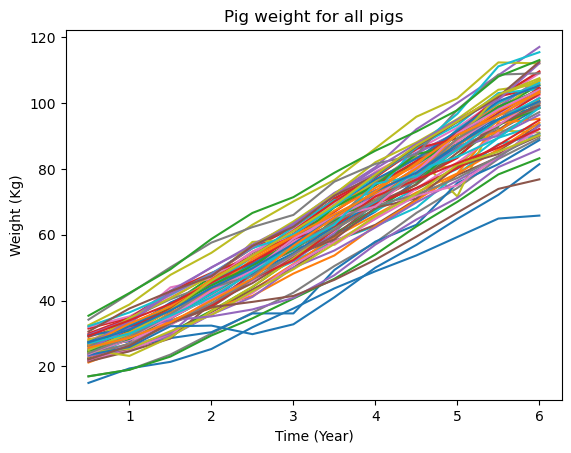

In [7]:
import matplotlib.pyplot as plt
for k in data["Pig"].unique():
    weights = data[data["Pig"]==k]["Weight"]
    time = data[data["Pig"]==k]["Time"]
    plt.plot(time/2, weights)
plt.xlabel("Time (Year)")
plt.ylabel("Weight (Kg)")
plt.title("Pig weight for all pigs")

As you can see, between all pigs, the trend is similar (weight increases), but they do not have the same exact intercept nor the same exact slope. In other words:
- A given pig has its own variance in initial weight
- A given pig has its own variance in weight increase

Thinking about the sources of variance is very important when designing a model. What we really mean is that the "weight" variable has two sources of variance: one is due to time, because as time increases so too do pigs. This variance is called "within-subject". We could look at the variance of each pig separately.

But to get a good statistical confidence in our recovered values, we need to also consider the variance between pigs: this is the "between-subject" variance.

Separating these sources is important. For example, consider fur length in dog breeds: clearly if you mix subject variability and breeds, you might reach a wrong conclusion.
To answer this question, let's use a mixed model. For this, please fill in the cells below, to indicate which quantity is what in the model

In [11]:
observations_var = "Weight"
fixed_effect_var = "Time"
random_effect_var = "Pig"

Let us fit the model now, shall we? We first fit the LMM with appropriate fixed and random effects and then the linear regression model without random effects.

In [12]:
md = smf.mixedlm("{} ~ {}".format(observations_var, fixed_effect_var), data, groups=data[random_effect_var], re_formula="~{}".format(fixed_effect_var))
mdf = md.fit(method=["lbfgs"])
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  Weight    
No. Observations:  861      Method:              REML      
No. Groups:        72       Scale:               6.0372    
Min. group size:   11       Log-Likelihood:      -2217.0475
Max. group size:   12       Converged:           Yes       
Mean group size:   12.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.739    0.550 28.603 0.000 14.660 16.817
Time              6.939    0.080 86.925 0.000  6.783  7.095
Group Var        19.503    1.561                           
Group x Time Cov  0.294    0.153                           
Time Var          0.416    0.033                           
===========================================================

"""

In [13]:
fm = smf.ols("{} ~ {}".format(observations_var, fixed_effect_var),data)
fm = fm.fit()
fm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     9584.
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:01:53   Log-Likelihood:                -2916.6
No. Observations:                 861   AIC:                             5837.
Df Residuals:                     859   BIC:                             5847.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.7053      0.521     30.161      0.000      14.683      16.727
Time           6.9467      0.071     97.900      0.000       6.807       7.086
==============================================================================
Omnibus:                       97.925   Durbin-Watson:                   0.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.236
Skew:                          -0.734   Prob(JB):                     3.98e-38
Kurtosis:                       4.628   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We ran two models above. One assumes a random intercept and random slope for each pig: in other words, each pigs has its own growth-rate and initial weight baked in. The other one attempts to model only the effect of time.

The **mean** values estimated will not change much, if at all. Inspect the above two, for the OLS Regression (Fixed effect model) and the MixedLM (Random + Fixed effect model). Look at the coefficient for the intercept and time: they are nearly the same! 


Based only on the information in the **fixed model**, what would be the expected weight of a pig at the 12th timepoint ? Would the couch endure it?

In [14]:
15.7053 + 6.9467*12

99.06569999999999

But wait! That can't be right, can it? Recall the weights we plotted above: we **know for a fact** that some pigs are above 100kgs.

<img src="imgs/impossible.jpg"/>

That's because we only considered the **mean**. The fixed effect has lost information about the different pigs, and we cannot consider a more meaningful approach of *maximal weight* (ie: fattest pig in our sample).

Indeed, what we did with the fixed approach was to compute the weight w as:
$$ w = w_{intercept} + t_{slope} * 12 $$

Or rewritten:
$$ w = w_{fixed} + t_{fixed} * 12 $$

But we could instead consider the mixed model as:

$$ w = w_{fixed} + w_{random} + t_{fixed} * 12 + t_{random} * 12 = w_{fixed} + w_{random} + (t_{fixed} + t_{random}) * 12$$

For this, let's get the random slope of our fattest growing pig and likewise fattest piglet.

In [15]:
intercepts = []
time = []
for x in list(mdf.random_effects.values()):
    # We combine both the group intercept and the fixed effect intercept to get the participant's actual intercept
    intercepts.append(x['Group'] + mdf.fe_params['Intercept'])
    # Likewise
    time.append(x['Time'] + mdf.fe_params['Time'])
biggest_intercept = max(intercepts)
biggest_time = max(time)

print(biggest_intercept)
print(biggest_time)

27.810886979233736
8.143677589478592


Based on the found intercept and time coefficient, assume you were offered to either keep your couch or to choose now instead a 130 kgs-supporting couch. Which one would be closer to the *worst-case* weight? (In other words, which couch would minimize the weight error?)

In [16]:
biggest_intercept + biggest_time*12 # We would thus need 130 kg couch instead to be safe!

125.53501805297685

### 1.2. Where are the design matrices?
In the example above, we simply gave you the data. You had to decide the variables to set as fixed effect and random effect, but that's it. In practice, you will often have to think about the design matrices themselves, which relate to your experimental design. Let's think about it for a bit and break down our design for the above experiment in appropriate matrices.<br>
First off, the observations. Each observation is a single scalar: the weight of pig i at time k:

In [17]:
data['Weight']

0       26.50000
1       27.59999
2       36.50000
3       40.29999
4       49.09998
         ...    
856     73.19995
857     81.69995
858     90.29999
859     96.00000
860    103.50000
Name: Weight, Length: 861, dtype: float64

In [18]:
interactive_MCQ(5,2)

HTML(value='<h3>Now, if we look at our β, it should be</h3>')

RadioButtons(description='Choose:', layout=Layout(width='100%'), options=('A matrix in the present case', 'A v…

Output()

*Hint: Think of what we are trying to express! Intuitively, we say that weight = timepoint x coefficient + pig category x another coefficient + modeling noise*

Now, how do we make the design matrix? Well, it is very simple. For each fixed effect **variable**, we model one column. The lines correspond to the observations.
To give you a concrete example, let's imagine that I conduct an experiment. I flip a coin, obtaining head or tail. Depending on the result, I decide to either put my participant in a dark room or in a lit room, and I then record the time this participant takes to fall asleep. My hypothesis is that the presence or absence of light has an impact on this time to sleep (tts). I am also curious about the room temperature, and decide to model three temperatures: 
- 1°C
- 19°C
- 38°C

Note that I do not want a general statement on room temperatures, only these three specific temperatures.

Because I am trying lit against dark room and want to test for presence against absence of light for three fixed temperatures, it is clear that the "light" condition is a fixed factor. Likewise, the room temperature is also a fixed factor.

Here are the observations I gathered for the tts (in seconds):
```python
tts
120
135
150
400
517
520
```

I am unfortunately a bit messy. While conducting one of my experiments in the dark, I mess up my documents and shuffle my design matrices with previously considered designs. Here are the matrices I end up with:

```python
A
room lit  temperature
0         1°C         
0         19°C
0         38°C
0         1°C
0         19°C
0         38°C
1         1°C
1         19°C
1         38°C

B
room lit  temperature
0         1°C         
0         19°C
0         38°C
1         1°C
1         19°C
1         38°C

C
room lit  temperature
0         1°C         
0         1°C
0         1°C
1         1°C
1         1°C
1         1°C

D
room lit  temperature
0         1°C         
0         19°C
0         39°C
1         1°C
1         19°C
1         28°C

E
room lit  temperature 1  temperature 2 temperature 3
0         1                 0              0
0         0                 1              0
0         0                 0              1
1         1                 0              0
1         0                 1              0
1         0                 0              1

```

In [28]:
interactive_MCQ(5,3)

HTML(value='<h3>Which do you think would be *valid* design matrices (not necessarily *good*) for the fixed eff…

#### 1.2.1 Dummy coding

You might have noticed that A has wrong dimensions and thus cannot lead to the observations. Likewise, D contains temperatures outside of our experimentally allowed values, so it is not valid. C, likewise, models a fixed effect but does not include all potential values of room temperature - wrong for our experiment. But what of the others? Are they valid?

The room temperature, in this case, is a categorical variable. In some cases (consider breeds of dogs), there is no clear directionality (for example if I code rottveiler=1 and chow-chow=2, the latter is mathematically higher than the former although there is no clear ordering in reality - even if rated for cuteness). When no clear directionality is involved, you can split the categories as shown in matrix E.
Matrix E is basically matrix B rewritten **assuming that temperature has no directionality**. This is not totally true in this case, obviously, but you can see how it is done. For experimental conditions, such as stimuli, directionality is often not expected, so knowing how to move from B to E is useful :)


<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>The contrast matrix</b></p>
        <p style='text-indent: 10px;'> E is actually what we call a *contrast matrix*. The reason for this is that we have now one $\beta$ coefficient for each category value in a categorical variable. This means we can now look at the impact of each combination. For example, in the case of breeds of dogs, we can look at the effect of chow-chow against rottveiler, or rottveiler against doberman and so on. This is particularly useful when looking at stimulus conditions in neuroscience, as you'll see in the next sections.</p>
    </span>
    </div>

Here's what I remember from memory: I first put the participant in the lit room, and chose decreasing temperature for the room, exploring all temperature settings. I then put the participant in the dark, and chose increasing temperature, exploring all settings. Can you design the dataframe that would correspond to this design matrix? To help you, here is an example, showcasing how you can do matrix D from above:

```python
matrix_D = pd.DataFrame({'room lit': ['no', 'no', 'no', 'yes', 'yes', 'yes'], 'temperature': [1, 19, 39, 1, 19, 39]})
```

In [29]:
design_matrix = pd.DataFrame({'room lit': ['yes', 'yes', 'yes', 'no', 'no', 'no'], 'temperature': [39, 19, 1, 1, 19, 39]})

Great! Now you now the basics of a design matrix. As you can see, it is a fairly easy thing to do!
Let's move away from our piggies and back to fMRI now!

## 2. Moving from univariate observations to multivariate: the GLM

You've seen above that we used a linear model to relate our experimental conditions with the observations.
But most of the time (such as in fMRI), our observations are not just a single scalar: they are multivariate quantities. Images consist of several pixels, physical experiments might record multiple different measurements at the same time - and in fMRI we have several voxels per volume.

How does the formalism above fare, when we extend to such a scenario? Well, the *General Linear Model* is one way to extend what we've seen to cases of several dimensions and the answer is: it fares nicely.
In the case of fMRI, we don't have a single variable: every voxel or brain region is a separate variable, for which we want to solve the system. For this purpose, we need to use what is called a *General Linear Model*.


The equation of the GLM you've seen above is still the following:

<p style="font-size:25px;">$$Y = X\beta + Zu + \epsilon$$</p>

The only difference is that now, $\beta$ and $u$ are matrices and $\epsilon$ is a vector!

### 2.1 Analysis levels in fMRI

In fMRI it turns out you can actually do the GLM in two steps, called *analysis levels*.

The first step is conducted at the individual participant level. It accounts for the fixed effects in your experiment (so $X\beta$).
The higher order analysis is done by aggregating the individual model's results. This second level accounts for the random effect ($Zu$). In general this effect is due to population, but you can imagine different random effects as we discussed previously.

We'll now teach you how to apply the GLM, first at the single participant level.

### 2.2 Loading the data

The GLM should be done on data that have been preprocessed. To save you some time, we'll use data taken from nilearn's <a href="https://nilearn.github.io/stable/auto_examples/00_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-00-tutorials-plot-single-subject-single-run-py">GLM tutorial</a>. Run the cell below to load them!

In [30]:
from nilearn.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()

Let's have a look at the data in there! You'll see that the functional data is several images:

In [31]:
subject_data.func

['/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
 '/home/jovyan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img',
 '/home/jovyan/nilearn_data/spm_audito

Many volumes! But what are they, exactly? Let's open one of them to see!

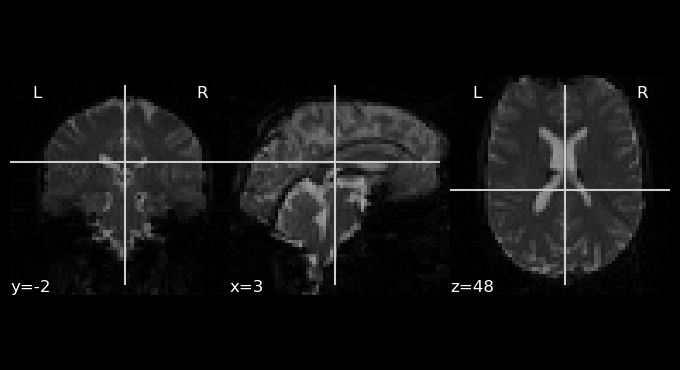

In [32]:
import nibabel as nib
from nilearn import plotting

img=nib.load(subject_data.func[0])
plotting.plot_anat(img)

As you can see there are all 3D volumes. We need to aggregate them all in a timeserie before we can run our GLM. 
This can be done easily with nilearn's **concat** function:

In [33]:
from nilearn.image import concat_imgs, mean_img
fmri_img = concat_imgs(subject_data.func)

Great! Let's now load the experimental design. In this experiment, subjects could be in two conditions:
- **active**, where they were subjected to **auditory** stimulation
- **rest** otherwise

We alternated between blocks of each condition, lasting 42 seconds each. Here is the list of these events:

In [34]:
events = pd.read_table(subject_data['events'])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


<div class=\"warning\" style='background-color:#C1ECFA; color: #112A46; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span>
    <p style='margin-top:1em; text-align:center'>
    <b>💡 Where to find these event files ? 💡</b></p>
    <p style='text-indent: 10px;'>
    Here we are showing you a nice example, where everything is already nicely put in its place. What if you wanted to load events from say an openneuro dataset? How should you proceed? 
        Well, let's take a practical example. Go to <a href="https://openneuro.org/datasets/ds004226">this dataset</a> (which should be familiar) and navigate to the func folder of subject sub-001. In there, we see several things, but let's focus on files that end in events.tsv:
        <img src="imgs/event_files.png"/>
        
These files are exactly those that contain for each session the events in the appropriate format. As a consequence, you should download them. We give an example cell at the very end of the notebook, as it could be useful for your project :)
    </p></span>
</div>

This way of specifying the stimulations is pretty standard in fMRI: the software will then construct for you the corresponding design matrix, based on repetition time and other regressors you might want to add. Let's first start with only our regressors of interest, plus noise.

In this experiment, the TR of acquisition was **7 seconds**.

In the cell below, we specify the model and fit it to our data and events (which is our experimental design, again!)

In [35]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)

Great, let's inspect first the design matrix that the software created for us, shall we?

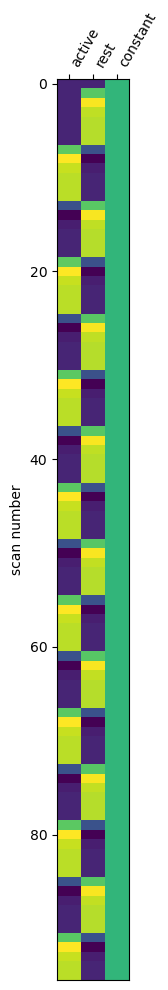

In [36]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

You can see that we have alternating blocks of active and rest conditions, plus a constant. What you  might wonder, however is **why is it not binary**? Well, this has to do with the nature of fMRI. We need to talk about what is called the hemodynamic response function (HRF).

## 3. The HRF: neural basis and modelling

One core assumption of GLM modelling is that the brain can be modelled as a linear time invariant system (LTI). 
Informally, it means that when I subject the brain to two stimulations, A and B, the total signal I observe can be decomposed as the sum of the effect of A and the effect of B on the brain.
(If you need more information on LTI systems, check out <a href="https://www.youtube.com/watch?v=Y8iFJVmSQIk">this video</a> for example).

Just to make it a bit clear anyway, here the example of a very simple LTI system, the function F(x) = x.
<br>Clearly $F(inputA) + F(inputB) = F(inputA + inputB)$, so linearity is very easy to check here. Visually, it would look like this:

<img src="imgs/lti_example.png"/>

The core idea is that the brain is the same in fMRI!
When you show first a stimulus A, and then a stimulus B, the brain will have a way of response for each. But the total effect you observe will be the linear combination of response to A and response to B.
<br>
### 3.1 The impulse response of the brain

When the brain is presented with a very brief signal (so brief we can call it an impulse), it will respond with a function that has a very characteristic shape: the HRF. This profile is really typical:
<img src="imgs/spm_example_resp.png"/>

As you have probably seen in other courses, having the impulse response of a system is very useful. All signals can be decomposed as a weighted sum of impulses. Imagine having this time three impulses, evenly spaced in time. Two of them will be at 0.5 amplitude, while the middle one will be at 1.0 amplitude. At each peak, I can put my HRF times the peak's amplitude. Here's what it would look like:

<img src="imgs/multiple_inputs_hrf.png"/>


This operation is called a **convolution**. Summing up all response stimulations is how you obtain the above picture.



<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Relevance of the HRF in the GLM</b></p>
        <p style='text-indent: 10px;'> 
            The goal of the GLM is to determine the response of the brain to a given stimulation. In other words, we are trying to find what the **BOLD response** will look like for a given stimulus. What do we know?</p>
        <ul>
            <li>The stereotypical response function to stimulation (the HRF)</li>
            <li>Stimulus timing and type (your experimental design)</li>
            <li>The brain output (the fMRI signal)</li>
        </ul>
        Because the stimuli are inputs to the brain, and the brain is LTI with impulse response being the HRF, what we can do is <b>convolve the stimuli with the HRF</b> and use this new convolved design matrix as input to the GLM. This is EXACTLY what you see in the design matrix below: the signal is no longer constant, because it has been convolved with the HRF!
    </span>
    </div>

To drive our point home, let's do the convolution of an experimental condition (rest), which starts at timepoint 0, and will be set to 1 for 42 samples before returning to zero. We will convolve it with the HRF, and compare it with the design matrix.

Notice that the HRF takes some time to return to zero!
To convince you, let's include thus about 12 timepoints **after** our last stimulation, just to be on the safe side.

To do this, let's first create some quantites. We must know the following:

- The time of each frame. You will have to create frames, starting from zero and extending to 55 seconds, spaced by 7 seconds (our TR).
- The experimental condition start and end: in this case, from 0 to 42, with a value of 1.
- The **oversampling** parameter. This is for the stability of the convolution. The idea is simple: we oversample the signal, convolve, and then downsample to go back to our scan times. In your case, the oversampling will be 50 (so we take 50 samples in between scans)

In [37]:
start_time = 0 # Replace with start time please
end_time = 55 # Replace with end of not stimulation but where we want our frame time to end!!
tr = 7 # What is our TR?
frame_times= np.asarray(list(range(start_time, end_time, tr)))

onset = 0 # Replace with the time at which stimulus starts
duration = 42 # Replace with the duration of the stimulus
amplitude = 1 # Replace with amplitude of the stimulus during stimulation

exp_condition = np.asarray([[onset], [duration], [amplitude]])

Great! Now, let's oversample our condition, shall we?

Text(0.5, 1.0, 'Frame time length: 8 / Total signal length: 572')

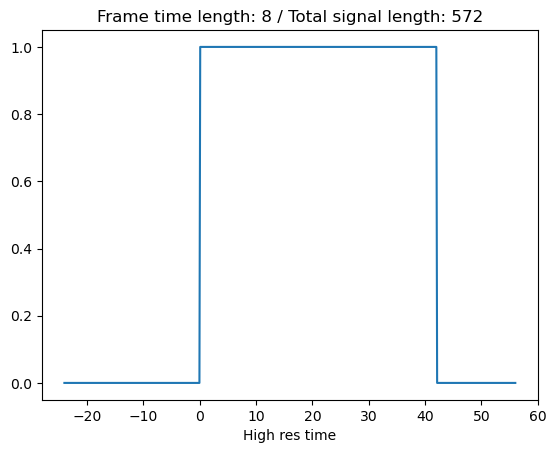

In [38]:
from nilearn.glm.first_level.hemodynamic_models import _sample_condition, _resample_regressor, glover_hrf

oversampling_factor=50

hr_regressor, hr_frame_times = _sample_condition(exp_condition, frame_times, oversampling=oversampling_factor)

plt.plot(hr_frame_times, hr_regressor)
plt.xlabel('High res time')
plt.title('Frame time length: {} / Total signal length: {}'.format(len(frame_times), len(hr_regressor)))

Notice that we have indeed oversampled our array. We've also added a bit of negative values: again this is for the stability of the convolution, to make it start from a clean zero signal around boundaries :)

Now, we can convolve our HRF with our high resolution regressor. Here it is:

Text(0.5, 0, 'High res time')

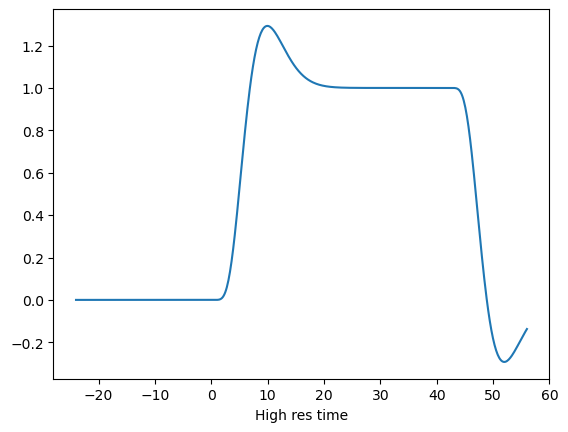

In [39]:
hrf = glover_hrf(tr=tr)
conv_reg = np.array([np.convolve(hr_regressor, hrf)[:hr_regressor.size]])

plt.plot(hr_frame_times, conv_reg.T)
plt.xlabel('High res time')

Nice! It remains to resample to proper resolution!

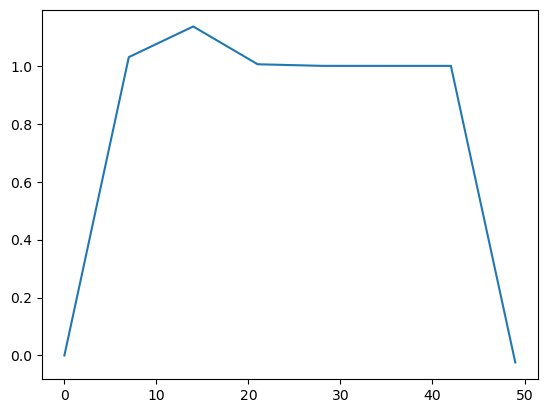

In [40]:
computed_regressors = _resample_regressor(
            conv_reg, hr_frame_times, frame_times)

plt.plot(frame_times, computed_regressors)

How close are we to what was found in the design matrix?

/tmp/ipykernel_10073/3029458749.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(fmri_glm.design_matrices_[0]['rest'][:49])


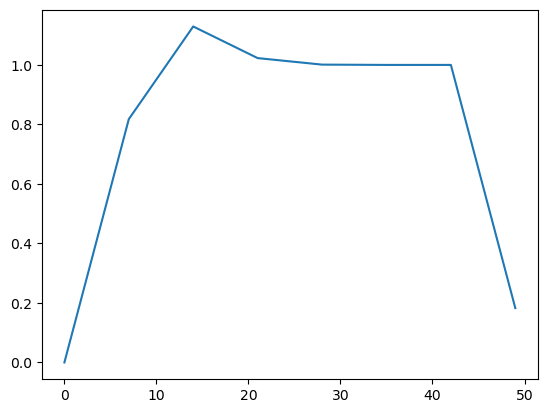

In [41]:
plt.plot(fmri_glm.design_matrices_[0]['rest'][:49])

Not too far off, but there's a difference still, right? Why is that?
**Because in the design matrix the regressors are orthogonalized with respect to each other**, hence the disparity you observe. You are hopefully convinced still that convolution with HRF is the reason you observe this:

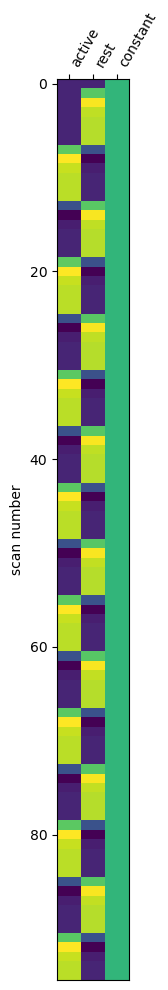

In [42]:
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

## 4. Using the GLM in fMRI

We've taken a big detour to make you really understand what you see in the design matrix and *why* it shows up this way. The GLM from above, still, is fit to your data. I would like to know now, based on this model, which regions of the brain could be associated to the *active* condition **compared to the rest condition**.

In other words, we want to **contrast** the active and rest conditions. This is done by building what is - aptly - called a contrast.
Remember: in our modelling, what we fitted are the $\beta$ coefficients. In particular, we will have here three beta vectors:
<p style="font-size:20px;">$\vec{\beta_{active}}$,  $\vec{\beta_{rest}}$,  $\vec{\beta_{constant}}$</p>

My $\beta$ matrix would look like this:
<p style="font-size:20px;">$$\beta =
\begin{bmatrix}
\vec{\beta_{active}}\\
\vec{\beta_{rest}}\\
\vec{\beta_{constant}}\end{bmatrix}$$
</p>

If I now wish to compute the effect of active minus rest, obtaining the contrast $c_{active - rest}$, I should thus multiply like so:

<p style="font-size:20px;">$$c_{active - rest} = 
\begin{bmatrix}
1 & -1 & 0\end{bmatrix}
\begin{bmatrix}
\vec{\beta_{active}}\\
\vec{\beta_{rest}}\\
\vec{\beta_{constant}}\end{bmatrix}$$
</p>

This is what it means to define a contrast. Let's do it now in practice. First, let's define our conditions. Can you find the vectors necessary to extract the rest and active conditions from the above beta matrix?

In [43]:
# Create the dictionary of the conditions

conditions = {
    'active': np.array([1, 0, 0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'rest':np.array([0, 1, 0]) # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
}

active_minus_rest = conditions['active'] - conditions['rest']

If we plot it, it will look like this:

<Axes: label='conditions'>

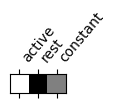

In [44]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE

Now, let's finally compute the contrast! We form a t-statistic, and obtain a z-score map of the beta coefficients of active minus rest like so:

In [45]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

Let's visualize it!

Nilearn is kind enough to also provide us with visualization tools, so we can do this:

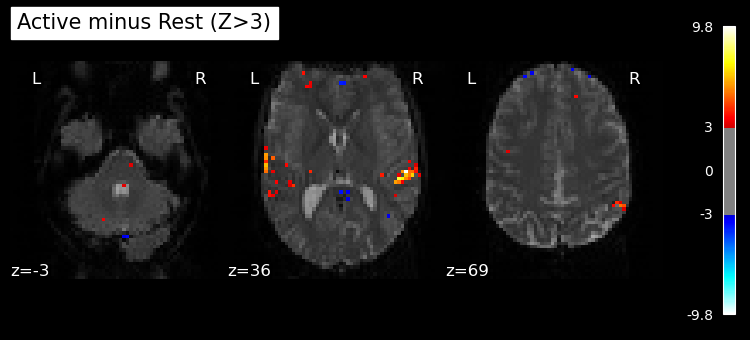

In [46]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()

### 4.1 A not-so insignificant issue: multiple-comparisons

Let's think for a moment. We have a lot of voxels. For each such voxel, we've performed a statistical test to assess if the difference between the two conditions is significant. Yet, we only showed results for an arbitrary visualization threshold, without caring once about the significance or the p-value! 

The issue with the p-value here is that we conducted *many tests*, one per voxel. You've probably seen in statistics that this increases the odds of a false positive. In other words, regions turn out positive, simply because we've conducted many tests.

We need to control for this false-positive rate to have results that would be somewhat sensible. There are different ways to do it. To keep this tutorial simple, you'll use two procedures together:
- False discovery rate correction, where we control the expected number of false discoveries
- Removing isolated voxels (because the brain is locally smooth, an isolated peak is suspicious)

To do so, please fill below the cell with:
- Cluster size: any cluster smaller than 10 voxels is to be thrown away
- False discovery rate: we will use a threshold at 0.05

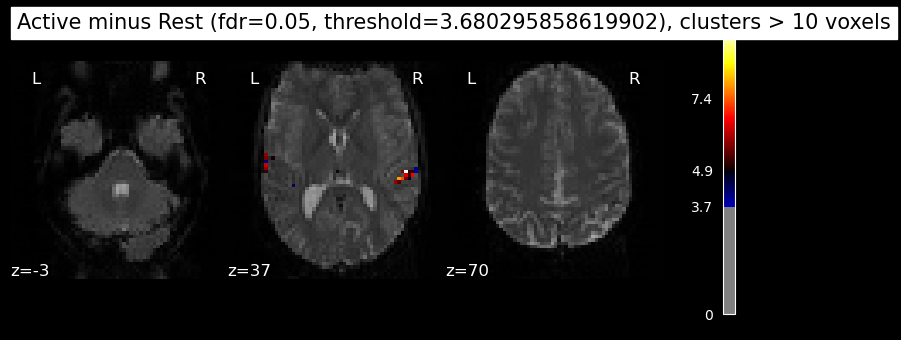

In [57]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()

Knowing that the participant was subjected to auditory stimulation, do these results make sense to you?


You now all the basics, which was the most painful part! Now that you understand how to move around the design matrix, we'll touch on some small details! :)

## 5. Including regressors in the model

You know the basics of the first level GLM, which is the most important part.
But how should we include additional regressors in the GLM? Let's say I have heart rate for example, how can I bake it into my computations to mitigate hearbeat's effect on my signal?

You've guessed it: we go back to our dear design matrix to modify it. In fact in the GLM, this is what you will always be manipulating since your observations are - well - what they are, and the beta coefficients are what you want to estimate.


The idea is simple: adding a regressor is simply done by adding a column to the design matrix. Because these regressors are events that confound our signal (they are not part of the experiment and corrupt our estimates), they are called...confounds or no-interest regressors!

For the purpose of this tutorial, we will model what is called the signal drift. The idea is simple: over time, the signal might decrease or increase, without relationship to the experimental paradigm itself (think for instance of fatigue). This variation in the mean of the signal over time can be modelled in the GLM to correct for it.
Let's create a drift model, and put it as regressor!
We will model it as a polynomial of order 3!

In [49]:
# Creation of the drift model:
from nilearn.glm.first_level.design_matrix import _make_drift

column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.asarray(list(range(0, 666, 7))), order=3, high_pass=None)

Beautiful! Let's add it to our design matrix, shall we?

In [50]:
design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

The resulting matrix looks like this:

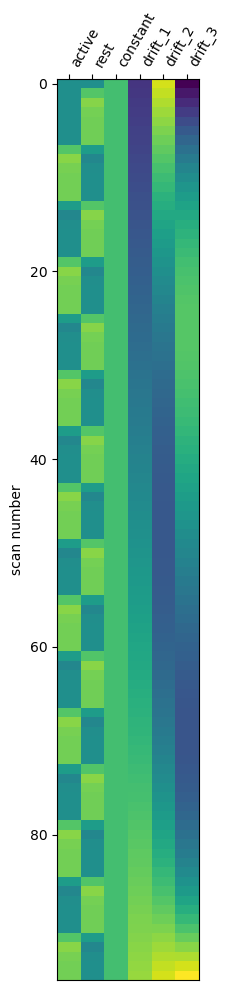

In [51]:
plot_design_matrix(design_mat)
plt.show()

You see that including additional regressors basically only boils down to updating your design matrix with relevant quantities. As in Nilearn the design matrix is a simple panda dataframe, this is *very* easy :)

Now, to fit the GLM with the design matrix is very easy. During fitting, instead of passing the events, we will pass the design matrix, such that this
```python
some_glm.fit(data, events=event_df)
```
becomes this instead:
```python
some_glm.fit(data, design_matrices=[my_design_matrix])
```

In our case, the function becomes:

In [52]:
fit_glm = FirstLevelModel(t_r=7.0, drift_model='None')
fit_glm.fit(fmri_img, design_matrices=[design_mat])

FirstLevelModel(drift_model='None', t_r=7.0)

You now know how to include any regressor in your design matrix!
In pratice, we often include as additional columns:
- Motion parameters
- Derivatives of the motion parameters
- Censoring of outlier volumes.

The censoring deserves at least a mention. Let's say that for my 96 volumes of interest here, every 10th volume I get an outlier because of motion somehow. I could try to make a single regressor for all volumes, like so:

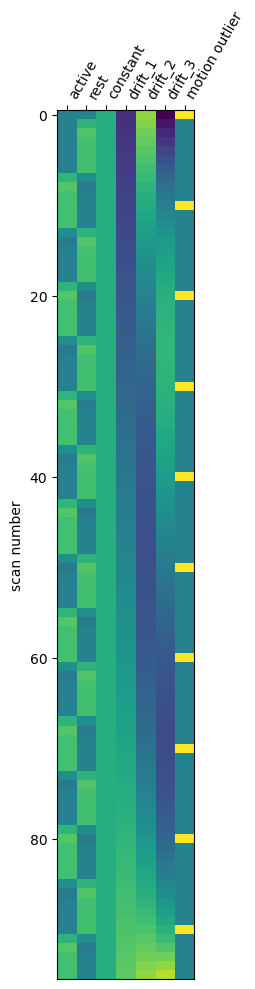

In [53]:
reg = np.zeros((96))
reg[::10] = 1


design_mat_regged = design_mat.copy()
design_mat_regged['motion outlier'] = reg

plot_design_matrix(design_mat_regged)
plt.show()

However, what we want implicitly is to censor the effect of each volume individually.
For this reason, when doing **motion outlier regression** like so in the GLM, you will usually add one regressor **per outlying volume**. In this case:

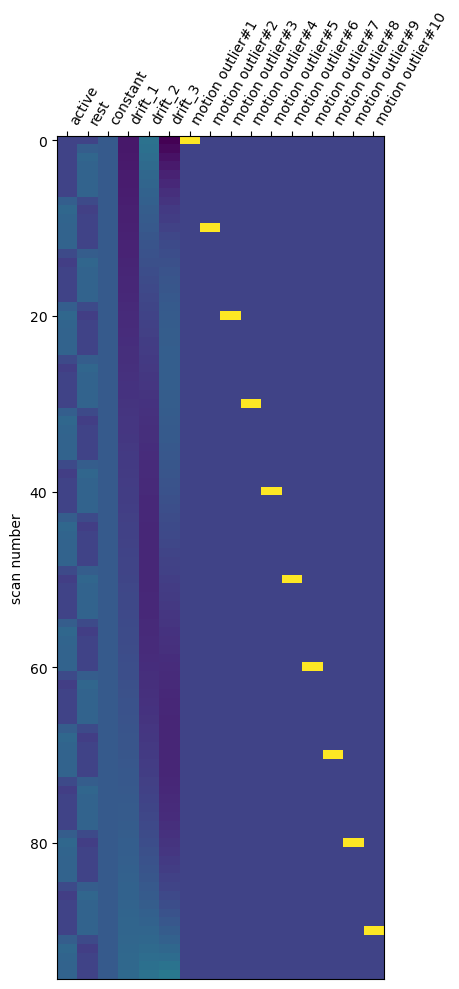

In [54]:
design_mat_regged = design_mat.copy()

for i in range(10):
    reg = np.zeros((96,))*0.0
    reg[i*10] = 1.0
    design_mat_regged['motion outlier#' + str(i+1)] = reg

plot_design_matrix(design_mat_regged)
plt.show()

## 6. Higher level analysis

Now, for the final part (which will be fast, don't worry!) - the higher level analysis.

This analysis aims to model the **random effect** of participants onto the effect you measure. In fMRI, the effect is a contrast map. As such, you will feed to the higher level model contrast maps.

The above dataset unfortunately does not contain several participants, so we will load another one to have you work on it.

In this experiment, participants performed a functional localizer task.
Participants are exposed to four types of stimulation:
- An auditory voice asks them to perform a mental computation (e.g: "Compute seventeen minus four")
- A video projected on a screen asks them to perform a mental computation (same example as above)
- An auditory voice reads a narrative sentence (e.g: "A storm is approaching")
- A video projected on the screen displays a narrative sentence

A first level GLM has already been run on these data. The contrast that has been created for each participant opposes mental computation (the first two stimuli) to narrative sentence reading/listening.

Let us load these contrast maps and look at one of them:

In [55]:
from nilearn import datasets

n_samples = 20
localizer_dataset = datasets.fetch_localizer_calculation_task(
    n_subjects=n_samples, legacy_format=False)




Dataset created in /home/jovyan/nilearn_data/brainomics_localizer



 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


In [56]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(localizer_dataset.cmaps[0])  


(ipykernel_launcher.py:10073): Gdk-WARNING **: 20:04:34.504: gdkdrawable-x11.c:952 drawable is not a pixmap or window


Despite being heavily present in the task, neither visual nor auditory regions pop out, compared to our previous contrast. Why do you think that is?

A: Because they are present in both condition, they cancel out!

Let's now conduct our second level analysis. To do this, we will specify our design matrix. We always need an intercept. Note that you could include here as a second regressor more interesting factors. In an interventional experiment, you could include a regressor to signal which subjects are 'control' and which ones are 'study'. You can also include effects such as the sex of your participants, their age etc.

In [53]:
design_matrix = pd.DataFrame([1] * n_samples, columns=['intercept'])

In [54]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(
    localizer_dataset.cmaps, design_matrix=design_matrix)

Great! Now we run the following to obtain the contrast at the population level:

In [55]:
z_map = second_level_model.compute_contrast(output_type='z_score')

Let's see what it looks like shall we?
Please, get the cleam map by thresholding the above z-map with an FDR with rate 0.05 and cluster size 10!

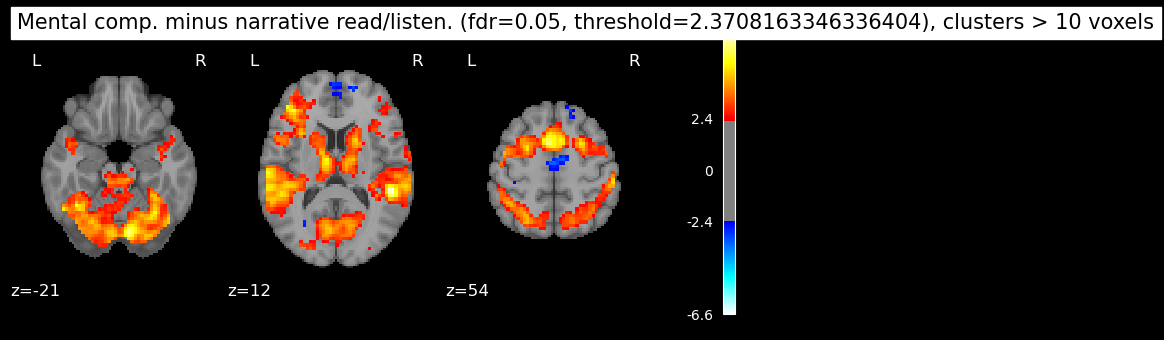

In [56]:
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# Saving it to disk
nib.save(clean_map, 'localizer_population_cleaned_map.nii.gz')

# And this is just to plot here!
plot_stat_map(clean_map, threshold=threshold,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Mental comp. minus narrative read/listen. (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()

We've saved the map as localizer_population_cleaned_map, so that you can have a look at it in FSLeyes :) Feel free to explore it. Do you think based on what you know of the brain that these patterns make sense?

In [57]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('localizer_population_cleaned_map.nii.gz')

## More to explore

You have seen the basics of the GLM. However, there are many more things to be covered. The most important one is the experimental design itself. You can read more on what is called event-related against block design <a href="https://afni.nimh.nih.gov/pub/dist/HOWTO/howto/ht03_stim/html/stim_background.html">here</a>.

Secondly, we've used one HRF model, but there are other slightly different HRFs you can use instead. You can also conduct smoothing, include various regressors...all these choices are usually driven by the experiment at hand! They are a bit out of scope of this tutorial. For now: you are done! Congratulations!

## Parenthesis: an example of how to load an event file from openneuro

The below cell shows you how to load the event file of run04 of sub-001 in the dataset ds004226 of openneuro (<a href="https://openneuro.org/datasets/ds004226/versions/1.0.0">this dataset)
    
<img src="imgs/event_files_demo.png"/>
    <center><i>This file specifically</i></center>

In [58]:
import os.path as op
from mne.datasets import sample
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

First, this cell will download the events file:

In [48]:
dataset_fmap = 'ds004226'
subject_fmap = '001' 

# Download one subject's data from each dataset
bids_root = op.join(op.dirname(sample.data_path()), dataset_fmap)

mkdir_no_exist(bids_root)



func_path = op.join(bids_root, 'sub-001', 'func')
mkdir_no_exist(op.join(bids_root, 'sub-001'))
mkdir_no_exist(func_path)

direct_file_download_open_neuro(file_list=['sub-001_task-sitrep_run-04_events.tsv'], 
                                file_types=['func'], 
                                dataset_id=dataset_fmap, 
                                dataset_version='1.0.0', 
                                save_dirs=[func_path])

Using default location ~/mne_data for sample...
Creating /home/jovyan/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.80TB/s]
Untarring contents of '/home/jovyan/mne_data/MNE-sample-data-processed.tar.gz' to '/home/jovyan/mne_data'


Download complete in 02m13s (1576.2 MB)
Attempting download from  https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:func:sub-001_task-sitrep_run-04_events.tsv


sub-001:func:sub-001_task-sitrep_run-04_events.tsv: 8.19kB [00:00, 12.1kB/s]

Ok


Now, we must load it. It has been placed into the functional folder of sub-001, given by the variable func_path. So to load it:

In [50]:
pd.read_csv(op.join(func_path, 'sub-001_task-sitrep_run-04_events.tsv'), sep='\t')

,onset,duration,response_time,trial_type
0,0.000004,4.539035,3.824330,NaN
1,4.540712,4.500184,2.120646,NaN
2,9.042640,4.498189,1.885302,NaN
3,13.542477,4.499530,1.793063,NaN
4,18.043677,4.499186,1.465999,impatience
...,...,...,...,...
85,510.045008,4.496098,1.989177,appreciation
86,516.043934,4.506962,2.167692,NaN
87,523.553172,4.484629,1.722772,sleepiness
88,529.540680,4.485448,2.165691,affection


Easy enough right? :)